In [ ]:
# env: devitomod
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import time
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [2]:
def pso_for_dir(func, lb, ub, reg_para=0.1, g=[], ieqcons=[], f_ieqcons=None, args=(), kwargs={}, 
        swarmsize=100, omega=0.05, phip=0.05, phig=0.5, maxiter=100, 
        minstep=1e-8, minfunc=1e-8, debug=False):
   
    assert len(lb)==len(ub), 'Lower- and upper-bounds must be the same length'
    assert hasattr(func, '__call__'), 'Invalid function handle'
    lb = np.array(lb)
    ub = np.array(ub)
    assert np.all(ub>lb), 'All upper-bound values must be greater than lower-bound values'
   
    vhigh = np.abs(ub - lb)
    vlow = -vhigh
    
    # Check for constraint function(s) #########################################
    obj = lambda x: func(x, reg_para=reg_para, *args, **kwargs)
    if f_ieqcons is None:
        if not len(ieqcons):
            if debug:
                print('No constraints given.')
            cons = lambda x: np.array([0])
        else:
            if debug:
                print('Converting ieqcons to a single constraint function')
            cons = lambda x: np.array([y(x, *args, **kwargs) for y in ieqcons])
    else:
        if debug:
            print('Single constraint function given in f_ieqcons')
        cons = lambda x: np.array(f_ieqcons(x, *args, **kwargs))
        
    def is_feasible(x):
        check = np.all(cons(x)>=0)
        return check
        
    # Initialize the particle swarm ############################################
    S = swarmsize
    D = len(lb)  # the number of dimensions each particle has
    x = np.random.rand(S, D)  # particle positions
    v = np.zeros_like(x)  # particle velocities
    p = np.zeros_like(x)  # best particle positions
    fp = np.zeros(S)  # best particle function values
    g = g  # best swarm position
    fg = obj(g)
    if len(g)==0:
        print('no initial parameter is given')
        fg = 1e100
    else:
        fg = obj(g)

    for i in range(S):
        # Initialize the particle's position
        x[i, :] = lb + x[i, :]*(ub - lb)
   
        # Initialize the particle's best known position
        p[i, :] = x[i, :]
        #p[i, :] = np.round(p[i, :]).astype(int)                     # added by Ning, to make sure p is int
        #p[i, :] = np.abs(p[i, :])                                   # added by Ning, to make sure p is abs
        # Calculate the objective's value at the current particle's
        fp[i] = obj(p[i, :])
        # fp[i] = obj(p[i, :]) + 0.1*f_ieqcons(p[i, :])              # added by Ning
       
        # At the start, there may not be any feasible starting point, so just
        # give it a temporary "best" point since it's likely to change
        if len(g)==0:
            g = p[0, :].copy()
        
        fg = obj(g)
        # If the current particle's position is better than the swarm's,
        # update the best swarm position
        if fp[i]<fg and is_feasible(p[i, :]):
            fg = fp[i]
            g = p[i, :].copy()           
        else:
            fg = fg
            g = g
       
        # Initialize the particle's velocity
        v[i, :] = vlow + np.random.rand(D)*(vhigh - vlow)
       
    # Iterate until termination criterion met ##################################
    it = 1
    # plot_interval = 10
    while it<=maxiter:
        rp = np.random.uniform(size=(S, D))
        rg = np.random.uniform(size=(S, D))
        for i in range(S):

            # Update the particle's velocity
            v[i, :] = omega*v[i, :] + phip*rp[i, :]*(p[i, :] - x[i, :]) + \
                      phig*rg[i, :]*(g - x[i, :])
                      
            # Update the particle's position, correcting lower and upper bound 
            # violations, then update the objective function value
            x[i, :] = x[i, :] + v[i, :]
            mark1 = x[i, :]<lb
            mark2 = x[i, :]>ub
            x[i, mark1] = lb[mark1]
            x[i, mark2] = ub[mark2]

            # fx = obj(x[i, :]) + 0.1*f_ieqcons(x[i, :])              # added by Ning
            fx = obj(x[i, :])
            
            # Compare particle's best position (if constraints are satisfied)
            if fx<fp[i] and is_feasible(x[i, :]):
                p[i, :] = x[i, :].copy()
                fp[i] = fx

                # Compare swarm's best position to current particle's position
                # (Can only get here if constraints are satisfied)
                if fx<fg:
                    if debug:
                        print('New best for swarm at iteration {:}: {:} {:}'.format(it, x[i, :], fx))

                    tmp = x[i, :].copy()
                    stepsize = np.sqrt(np.sum((g-tmp)**2))
                    if np.abs(fg - fx)<=minfunc:
                        print('Stopping search: Swarm best objective change less than {:}'.format(minfunc))
                        return tmp, fx
                    elif stepsize<=minstep:
                        print('Stopping search: Swarm best position change less than {:}'.format(minstep))
                        return tmp, fx
                    else:
                        g = tmp.copy()
                        fg = fx
                        # print('updating..........................................')
        #     plt.scatter(range(len(x[i])), x[i], s=0.1)
        # plt.xlabel('Index')
        # plt.ylabel('Position')
        # plt.title('Particle Positions - Iteration {}'.format(it))
        # plt.show()            

        if debug:
            print('Best after iteration {:}: {:} {:}'.format(it, g, fg))
        it += 1

        # if it % plot_interval == 0:  # Plot only when iteration is an integral multiple
        #    plt.show()

    print('Stopping search: maximum iterations reached --> {:}'.format(maxiter))
    
    if not is_feasible(g):
        print("However, the optimization couldn't find a feasible design. Sorry")
    return g, fg

## Geometry

In [ ]:
# parameters
inputfile = 'data/data_noise.npz'
inputdata = np.load(inputfile)

# Receivers
r = inputdata['r']
dr = r[0, 1]-r[0, 0]
nr = r.shape[1]

# Sources
s = inputdata['s']
ds = s[1, 1]-s[1, 0]
ns = s.shape[1]

# models
rho = inputdata['rho']
vel = inputdata['vel']

# Time axis
t = inputdata['t']
ot, dt, nt = t[0], t[1]-t[0], len(t)

# Axes
x, z = inputdata['x'], inputdata['z']
dx, dz = x[1] - x[0], z[1] - z[0]

# Wavelet
wav = inputdata['wav']
wav = wav / np.max(np.abs(np.fft.fft(wav))*dt) 
wav_c = np.argmax(wav)

# pressure and velocities
pup   = inputdata['p']         # organized as (R, S, T)

(500.0, 2100.0, 5.864, 0.0)

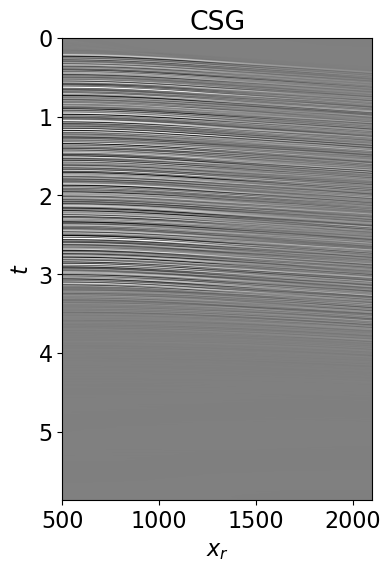

In [4]:
plt.figure(figsize=(4,6))
plt.imshow(pup[:,-1].T, cmap='gray', vmin=-0.1*np.abs(pup).max(), 
              vmax=0.1*np.abs(pup).max(), extent=(r[0,0], r[0,-1], t[-1], t[0]))
plt.xlabel(r'$x_r$')
plt.ylabel(r'$t$')
plt.title('CSG')
plt.axis('tight')

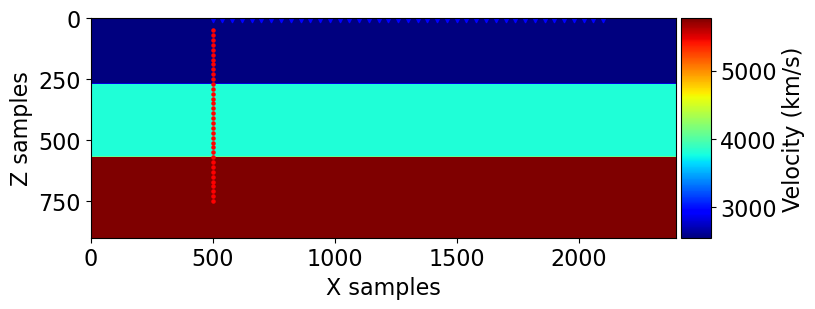

In [7]:
plt.figure(figsize=(8,8))
plot = plt.imshow(vel,cmap='jet',origin='upper',extent = (x[0], x[-1], z[-1], z[0]))
plt.xlabel("X samples")
plt.ylabel("Z samples")
plt.scatter(s[0, 0::10], s[1, 0::10], marker='o', s=5, c='r')
plt.scatter(r[0, 0::10],  r[1, 0::10], marker='v', s=20, c='b')
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(plot, cax=cax)
cbar.set_label('Velocity (km/s)')

plt.show()

## remove direct arrival try on one shot gather

In [13]:
def objective(shifts, reg_para=0.1):
    # Correcting shift values to ensure they're integers
    shifts = np.round(shifts).astype(int)
    shifts = np.abs(shifts)
    shifts[shifts > 350] = 350

    diff = np.diff(shifts)
    total_penalty = np.linalg.norm(diff, ord=2)

    new_vector = np.zeros([len(vector_list[0]), len(vector_list)])
    for i in range(len(vector_list)):
        new_vector[:,i] = np.concatenate((vector_list[i][shifts[i]:], np.zeros(shifts[i])))
    stack_sum = np.sum(new_vector, axis=1)
    total_eng = np.linalg.norm(stack_sum[:], ord=4)

    # print('total_eng is', total_eng)
    # print('total_penalty is', total_penalty)
    final_value = -1*total_eng + reg_para*total_penalty
    # print('final_value is', final_value)

    return final_value  

In [ ]:
best_shifts = np.zeros([nr,])
aligned_p = np.zeros([ns, nt, nr])
shift_p = np.zeros([ns, nr])

for i in range(ns-1, 0, -1):
    # Computation goes here
    print(i)  # For demonstration, replace this with your computation
    
    # Record the start time
    start_time = time.time()

    depth_s = s[1,i]
    vel_tru = int(s[1,i]/dz)
    vel_max = vel[:vel_tru].max()
    vel_min = vel[:vel_tru].min()
    vel_ave = vel[:vel_tru].mean()
    tmin=np.sqrt((r[0]-500)**2 +(np.ones_like(r[0])*depth_s-5)**2 )/vel_max/dt
    tmax=np.sqrt((r[0]-500)**2 +(np.ones_like(r[0])*depth_s-5)**2 )/vel_min/dt
    tave=np.sqrt((r[0]-500)**2 +(np.ones_like(r[0])*depth_s-5)**2 )/vel_ave/dt
    tmax_rea=np.linspace(0, 350, nr)

    tmin_min = tmin.min()
    tmax_min = tmax.min()
    tave_min = tave.min()
    
    # take one CSG to to align the direct arrival, first normalize the CSG
    vector_list = (pup[:,i]/pup[:,i].max()).tolist()

    # Define bounds for shifts
    ub= np.minimum(tmax-tmax_min, tmax_rea)
    ub[0] = 0.1
    lb=tmin-tmin_min

    # Initial guess
    obj_previous_best = objective(best_shifts,0)
    obj_tave = objective(tave-tave_min,0)
    if obj_previous_best > obj_tave:
        x0 = np.abs(tave-tave_min)
    else:
        x0 = np.abs(best_shifts)
    
    # The two term of the objective function
    reg = np.linalg.norm(np.diff(tave-tave_min), ord=2)
    new_vector = np.zeros([len(vector_list[0]), len(vector_list)])
    shift_test = np.round(tave-tave_min).astype(int)
    for k in range(len(vector_list)):
        new_vector[:,k] = np.concatenate((vector_list[k][shift_test[k]:], np.zeros(shift_test[k])))
    stack_sum = np.sum(new_vector, axis=1)
    eng_vector = np.linalg.norm(stack_sum[:], ord=4)
    # Regularization parameter
    reg_para = eng_vector/reg/175

    # Run PSO
    best_shifts, _ = pso_for_dir(objective, lb, ub, reg_para=reg_para, g=x0, swarmsize=100, omega=0.5, phip=0.9, phig=0.5, maxiter=35, debug=False, minstep=1e-4, minfunc=1e-4)

    # Apply best shifts to get the resultant vector
    best_shifts = np.round(best_shifts).astype(int)
    best_shifts = np.abs(best_shifts)

    new_vector = np.zeros([len(vector_list[0]), len(vector_list)])
    for j in range(len(vector_list)):
        new_vector[:,j] = np.concatenate((vector_list[j][best_shifts[j]:], np.zeros(best_shifts[j])))
    
    aligned_p[i] = new_vector*pup[:,i].max()
    shift_p[i] = best_shifts

    # Record the end time
    end_time = time.time()

    elapsed_time = (end_time - start_time)/60.
    print("Time taken:", elapsed_time, "min")
    

350
Stopping search: maximum iterations reached --> 35
Time taken: 3.795492728551229 min
349
Stopping search: maximum iterations reached --> 35
Time taken: 3.749049127101898 min
348
Stopping search: maximum iterations reached --> 35
Time taken: 3.7487136403719585 min
347
Stopping search: maximum iterations reached --> 35
Time taken: 3.747943166891734 min
346
Stopping search: maximum iterations reached --> 35
Time taken: 3.776516310373942 min
345
Stopping search: maximum iterations reached --> 35
Time taken: 3.880267794926961 min
344
Stopping search: maximum iterations reached --> 35
Time taken: 3.7461888909339907 min
343
Stopping search: maximum iterations reached --> 35
Time taken: 3.73919384876887 min
342
Stopping search: maximum iterations reached --> 35
Time taken: 3.7492544253667197 min
341
Stopping search: maximum iterations reached --> 35
Time taken: 3.752087958653768 min
340
Stopping search: Swarm best objective change less than 0.0001
Time taken: 3.3295153339703876 min
339
Sto

In [ ]:
np.savez('data/aligned_pnoise.npz', aligned_p=aligned_p, shift_pup=shift_p)

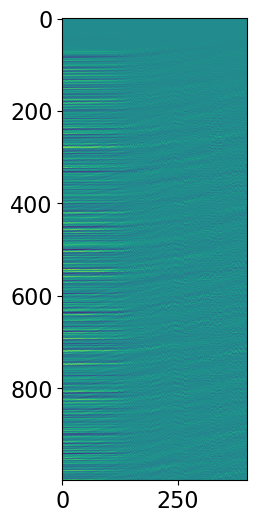

In [ ]:
plt.imshow(aligned_p[180,:1000])